In [1]:
!fuser -k /dev/nvidia0

In [2]:
!nvidia-smi

Wed May 15 07:14:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:21:00.0  On |                  N/A |
| 30%   35C    P8              22W / 260W |     55MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import sys
sys.path.append("..")
import tools
import evals
import matplotlib.pyplot as plt
import numpy as np
from lsst.daf.butler import Butler
import matplotlib as mpl
%load_ext autoreload
%autoreload 2

In [4]:
model_path = "../DATA/Model_test_5.keras"
tf_dataset_path = "/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/"
collection = "u/kmrakovc/"
val_index_path="/astro/users/kmrakovc/Projects/LSST_Streak_Detection/DATA/val_index1.npy"
repo_path ="/epyc/ssd/users/kmrakovc/DATA/rc2_subset/SMALL_HSC/"
threshold = 0.5
batch_size=10

In [5]:
def get_magnitude_bin (repo, output_coll):
    butler = Butler(repo)
    injection_catalog_ids = list(butler.registry.queryDatasets("injected_postISRCCD_catalog", collections=output_coll, instrument='HSC'))
    min_mag = 100
    max_mag = 0
    for injection_catalog_id in injection_catalog_ids:
        injection_catalog= butler.get("injected_postISRCCD_catalog", 
                                      dataId=injection_catalog_id.dataId, 
                                      collections=output_coll,)
        magnitudes = injection_catalog["mag"]
        min_mag = min (min_mag, injection_catalog["mag"].min())
        max_mag = max (max_mag, injection_catalog["mag"].max())
    return min_mag, max_mag
    

def plot_trail_histogram (NN_data, LSST_data, true_data=None):
    fig, ax = plt.subplots()
    bins = np.arange(4, 74, 5)
    if true_data is not None:
        ax.hist(true_data, bins=bins, histtype="step", label="True asteroids")
    ax.hist(NN_data, bins=bins, histtype="step", label="NN detected asteroids")
    ax.hist(LSST_data, bins=bins, histtype="step", label="LSST stack detected asteroids")
    ax.set_xlabel("Trail length")
    ax.set_ylabel("Count")
    ax.legend()
    return fig

def plot_magnitude_histogram (NN_data, LSST_data, true_data=None):
    fig, ax = plt.subplots()
    bins=np.arange(20,25.5,0.5)
    if true_data is not None:
        ax.hist(true_data, bins=bins, histtype="step", label="True asteroids")
    ax.hist(NN_data, bins=bins, histtype="step", label="NN detected asteroids")
    ax.hist(LSST_data, bins=bins, histtype="step", label="LSST stack detected asteroids")
    ax.set_xlabel("Magnitude")
    ax.set_ylabel("Count")
    ax.legend()
    return fig

In [6]:
def plot_mask_on_axis (mask, ax):
    cmap = mpl.colors.ListedColormap(['white', 'green', 'cyan', 'red'])
    ax.imshow(mask, cmap=cmap, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    labels = {0:'True Negative', 1:'True Positive', 2:'False Positive', 3:"False Negative"}    
    patches =[mpl.patches.Patch(color=cmap.colors[i],label=labels[i]) for i in range(len(cmap.colors))]
    ax.legend(handles=patches)
    return ax

def plot_input_on_axis (img, ax):
    ax.imshow(img, cmap="grey")
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

In [7]:
predictions_1 = evals.eval_tools.create_NN_prediction (tf_dataset_path+"test1.tfrecord", 
                                                       model_path, 
                                                       threshold=threshold)
print ("NN  prediction 1 created")
predictions_2 = evals.eval_tools.create_NN_prediction (tf_dataset_path+"test2.tfrecord", 
                                                       model_path, 
                                                       threshold=threshold)
print ("NN  prediction 2 created")
predictions_3 = evals.eval_tools.create_NN_prediction (tf_dataset_path+"test3.tfrecord", 
                                                       model_path, 
                                                       threshold=threshold)
print ("NN  prediction 3 created")
predictions_4 = evals.eval_tools.create_NN_prediction (tf_dataset_path+"test4.tfrecord", 
                                                       model_path, 
                                                       threshold=threshold)
print ("NN  prediction 4 created")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [8]:
inputs1, truths = tools.data.create_XY_pairs (tf_dataset_path+"test1.tfrecord")
tp1, fp1, fn1, mask1 = evals.eval_tools.get_mask(truths, predictions_1, batch_size=batch_size)
print ("Scoring 1 done")

inputs2, truths = tools.data.create_XY_pairs (tf_dataset_path+"test2.tfrecord")
tp2, fp2, fn2, mask2 = evals.eval_tools.get_mask(truths, predictions_2, batch_size=batch_size)
print ("Scoring 2 done")

inputs3, truths = tools.data.create_XY_pairs (tf_dataset_path+"test3.tfrecord")
tp3, fp3, fn3, mask3 = evals.eval_tools.get_mask(truths, predictions_3, batch_size=batch_size)
print ("Scoring 3 done")

inputs4, truths = tools.data.create_XY_pairs (tf_dataset_path+"test4.tfrecord")
tp4, fp4, fn4, mask4 = evals.eval_tools.get_mask(truths, predictions_4, batch_size=batch_size)
print ("Scoring 4 done")

Scoring 1 done
Scoring 2 done
Scoring 3 done
Scoring 4 done


In [9]:
NN_detected_asteroids_1m, \
true_asteroids_1m = evals.eval_tools.NN_comparation_histogram_data (predictions_1,
                                                                   val_index_path,
                                                                   repo_path,
                                                                   collection+"single_frame_injection_01",
                                                                   column_name="mag",
                                                                   batch_size=batch_size)
print ("Histogram data for 1 magnitudes created")
NN_detected_asteroids_1t, \
true_asteroids_1t = evals.eval_tools.NN_comparation_histogram_data (predictions_1,
                                                                    val_index_path,
                                                                    repo_path,
                                                                    collection+"single_frame_injection_01",
                                                                    column_name="trail_length",
                                                                    batch_size=batch_size)
print ("Histogram data for 1 trail_length created")
NN_detected_asteroids_2, \
true_asteroids_2 = evals.eval_tools.NN_comparation_histogram_data (predictions_2,
                                                                   val_index_path,
                                                                   repo_path,
                                                                   collection+"single_frame_injection_02",
                                                                   column_name="trail_length",
                                                                   batch_size=batch_size)
print ("Histogram data for 2 trail_length created")
NN_detected_asteroids_3, \
true_asteroids_3 = evals.eval_tools.NN_comparation_histogram_data (predictions_3,
                                                                   val_index_path,
                                                                   repo_path,
                                                                   collection+"single_frame_injection_03",
                                                                   column_name="trail_length",
                                                                   batch_size=batch_size)
print ("Histogram data for 3 trail_length created")
NN_detected_asteroids_4, \
true_asteroids_4 = evals.eval_tools.NN_comparation_histogram_data (predictions_4,
                                                                   val_index_path,
                                                                   repo_path,
                                                                   collection+"single_frame_injection_04",
                                                                   column_name="trail_length",
                                                                   batch_size=batch_size)
print ("Histogram data for 4 trail_length created")

Histogram data for 1 magnitudes created
Histogram data for 1 trail_length created
Histogram data for 2 trail_length created
Histogram data for 3 trail_length created
Histogram data for 4 trail_length created


In [10]:
LSST_stack_detected_asteroids_1m= evals.eval_tools.LSST_stack_comparation_histogram_data(repo_path,
                                                                                        collection+"single_frame_injection_01",
                                                                                        val_index_path,
                                                                                        batch_size=batch_size,
                                                                                        column_name="mag")
print ("LSST stack prediction 1m created")
LSST_stack_detected_asteroids_1t= evals.eval_tools.LSST_stack_comparation_histogram_data(repo_path,
                                                                                        collection+"single_frame_injection_01",
                                                                                        val_index_path,
                                                                                        batch_size=batch_size)
print ("LSST stack prediction 1t created")
LSST_stack_detected_asteroids_2= evals.eval_tools.LSST_stack_comparation_histogram_data(repo_path,
                                                                                        collection+"single_frame_injection_02",
                                                                                        val_index_path,
                                                                                        batch_size=batch_size)
print ("LSST stack prediction 2 created")
LSST_stack_detected_asteroids_3= evals.eval_tools.LSST_stack_comparation_histogram_data(repo_path,
                                                                                        collection+"single_frame_injection_03",
                                                                                        val_index_path,
                                                                                        batch_size=batch_size)
print ("LSST stack prediction 3 created")
LSST_stack_detected_asteroids_4= evals.eval_tools.LSST_stack_comparation_histogram_data(repo_path,
                                                                                        collection+"single_frame_injection_04",
                                                                                        val_index_path,
                                                                                        batch_size=batch_size)
print ("LSST stack prediction 4 created")

LSST stack prediction 1m created
LSST stack prediction 1t created
LSST stack prediction 2 created
LSST stack prediction 3 created
LSST stack prediction 4 created


True Positives: 779 False Positives: 763 False Negatives: 378
F1 score 0.5772508336420896 
Precision 0.5051880674448768 
Recall 0.6732929991356957


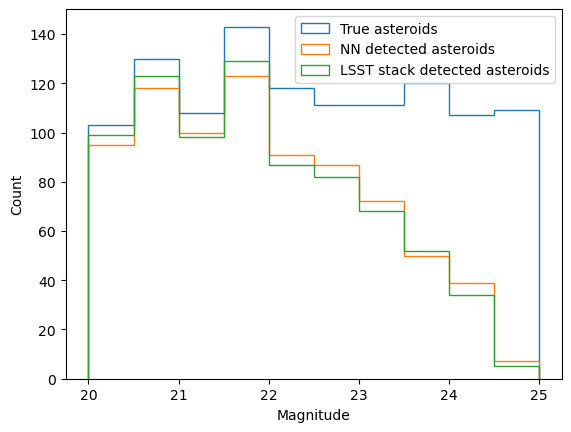

In [17]:
fig_1m = plot_magnitude_histogram (NN_detected_asteroids_1m, LSST_stack_detected_asteroids_1m, true_asteroids_1m)
tp=tp1.sum()
fp=fp1.sum()
fn=fn1.sum()
print ("True Positives:", int(tp),"False Positives:", int(fp), "False Negatives:", int(fn))
print ("F1 score", evals.eval_tools.f1_score (tp,fp,fn), 
       "\nPrecision", evals.eval_tools.precision (tp,fp,fn), 
       "\nRecall", evals.eval_tools.recall(tp,fp,fn))

True Positives: 779 False Positives: 763 False Negatives: 378
F1 score 0.5772508336420896 
Precision 0.5051880674448768 
Recall 0.6732929991356957


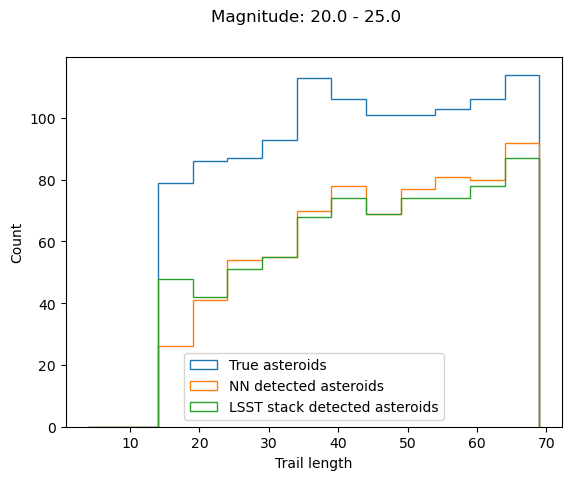

In [12]:
fig_1t = plot_trail_histogram (NN_detected_asteroids_1t, LSST_stack_detected_asteroids_1t, true_asteroids_1t)
minmag1, maxmag1 = get_magnitude_bin (repo_path, collection+"single_frame_injection_01")
_ = fig_1t.suptitle("Magnitude: "+str(round(minmag1, 1))+" - "+str(round(maxmag1, 1)))
tp=tp1.sum()
fp=fp1.sum()
fn=fn1.sum()
print ("True Positives:", int(tp),"False Positives:", int(fp), "False Negatives:", int(fn))
print ("F1 score", evals.eval_tools.f1_score (tp,fp,fn), 
       "\nPrecision", evals.eval_tools.precision (tp,fp,fn), 
       "\nRecall", evals.eval_tools.recall(tp,fp,fn))

True Positives: 329 False Positives: 768 False Negatives: 831
F1 score 0.29153743907842267 
Precision 0.2999088422971741 
Recall 0.2836206896551724


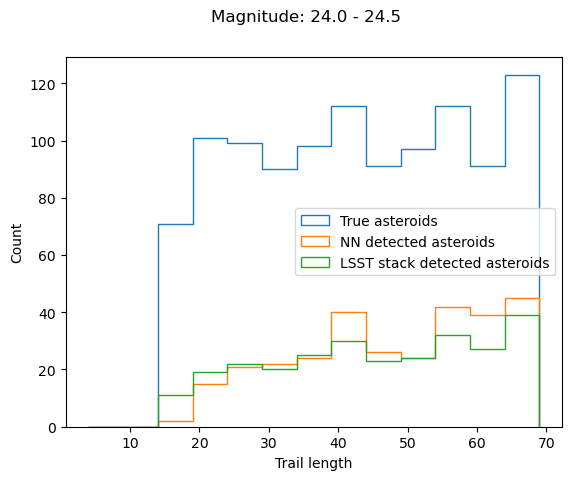

In [13]:
fig_2 = plot_trail_histogram (NN_detected_asteroids_2, LSST_stack_detected_asteroids_2, true_asteroids_2)
minmag2, maxmag2 = get_magnitude_bin (repo_path, collection+"single_frame_injection_02")
_ = fig_2.suptitle("Magnitude: "+str(round(minmag2, 1))+" - "+str(round(maxmag2, 1)))
tp=tp2.sum()
fp=fp2.sum()
fn=fn2.sum()
print ("True Positives:", int(tp),"False Positives:", int(fp), "False Negatives:", int(fn))
print ("F1 score", evals.eval_tools.f1_score (tp,fp,fn), 
       "\nPrecision", evals.eval_tools.precision (tp,fp,fn), 
       "\nRecall", evals.eval_tools.recall(tp,fp,fn))

True Positives: 85 False Positives: 765 False Negatives: 1068
F1 score 0.08487269096355467 
Precision 0.1 
Recall 0.07372072853425846


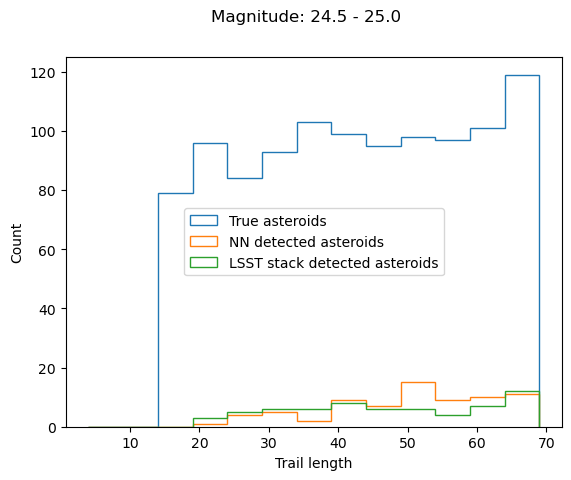

In [14]:
fig_3 = plot_trail_histogram (NN_detected_asteroids_3, LSST_stack_detected_asteroids_3, true_asteroids_3)
minmag3, maxmag3 = get_magnitude_bin (repo_path, collection+"single_frame_injection_03")
_ = fig_3.suptitle("Magnitude: "+str(round(minmag3, 1))+" - "+str(round(maxmag3, 1)))
tp=tp3.sum()
fp=fp3.sum()
fn=fn3.sum()
print ("True Positives:", int(tp),"False Positives:", int(fp), "False Negatives:", int(fn))
print ("F1 score", evals.eval_tools.f1_score (tp,fp,fn), 
       "\nPrecision", evals.eval_tools.precision (tp,fp,fn), 
       "\nRecall", evals.eval_tools.recall(tp,fp,fn))

True Positives: 5 False Positives: 770 False Negatives: 1153
F1 score 0.005173305742369374 
Precision 0.0064516129032258064 
Recall 0.004317789291882556


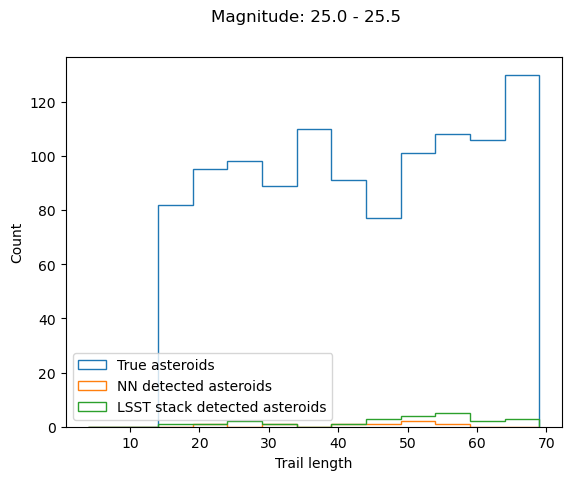

In [15]:
fig_4 = plot_trail_histogram (NN_detected_asteroids_4, LSST_stack_detected_asteroids_4, true_asteroids_4)
minmag4, maxmag4 = get_magnitude_bin (repo_path, collection+"single_frame_injection_04")
_ = fig_4.suptitle("Magnitude: "+str(round(minmag4, 1))+" - "+str(round(maxmag4, 1)))
tp=tp4.sum()
fp=fp4.sum()
fn=fn4.sum()
print ("True Positives:", int(tp),"False Positives:", int(fp), "False Negatives:", int(fn))
print ("F1 score", evals.eval_tools.f1_score (tp,fp,fn), 
       "\nPrecision", evals.eval_tools.precision (tp,fp,fn), 
       "\nRecall", evals.eval_tools.recall(tp,fp,fn))

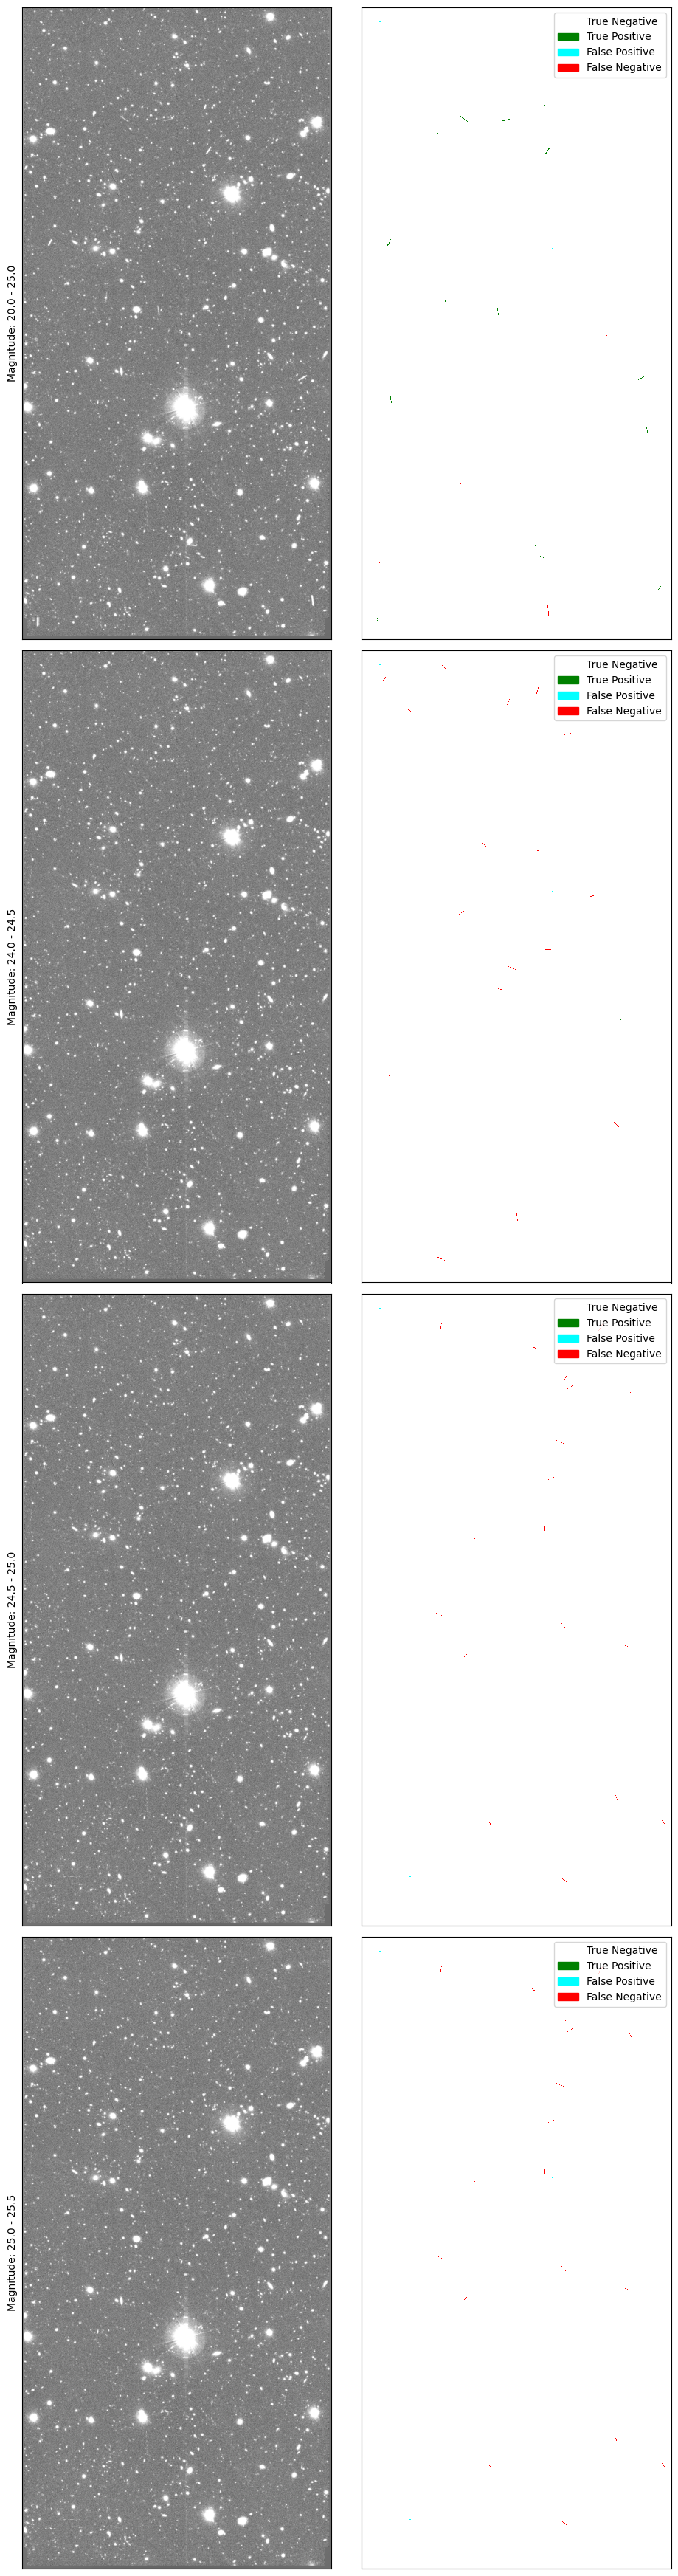

In [16]:
i=1
fig, ax = plt.subplots(4, 2, figsize=(10,35))
ax[0,1] = plot_mask_on_axis (mask1[i], ax[0,1])
ax[0,0] = plot_input_on_axis (inputs1[i], ax[0,0])
ax[0,0].set_ylabel("Magnitude: "+str(round(minmag1, 1))+" - "+str(round(maxmag1, 1)))

ax[1,1] = plot_mask_on_axis (mask2[i], ax[1,1])
ax[1,0] = plot_input_on_axis (inputs2[i], ax[1,0])
ax[1,0].set_ylabel("Magnitude: "+str(round(minmag2, 1))+" - "+str(round(maxmag2, 1)))

ax[2,1] = plot_mask_on_axis (mask3[i], ax[2,1])
ax[2,0] = plot_input_on_axis (inputs3[i], ax[2,0])
ax[2,0].set_ylabel("Magnitude: "+str(round(minmag3, 1))+" - "+str(round(maxmag3, 1)))

ax[3,1] = plot_mask_on_axis (mask3[i], ax[3,1])
ax[3,0] = plot_input_on_axis (inputs3[i], ax[3,0])
ax[3,0].set_ylabel("Magnitude: "+str(round(minmag4, 1))+" - "+str(round(maxmag4, 1)))
fig.tight_layout()